In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from tqdm import tqdm


In [7]:
DATA_DIR = 'H:\Anaconda\cvpr_4234-master\Assignment-1/train'
IMG_SIZE = 32
CATEGORIES = []

for i in os.listdir(DATA_DIR):
    CATEGORIES.append(i)

print(CATEGORIES)


['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [8]:
training_data = []

for c in CATEGORIES:
    path = os.path.join(DATA_DIR, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))   # read the image
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize the image
            img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
            training_data.append([img_gray, class_num])
        except:
            pass
        
print(len(training_data))

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:00<00:00, 5608.62it/s]

50000


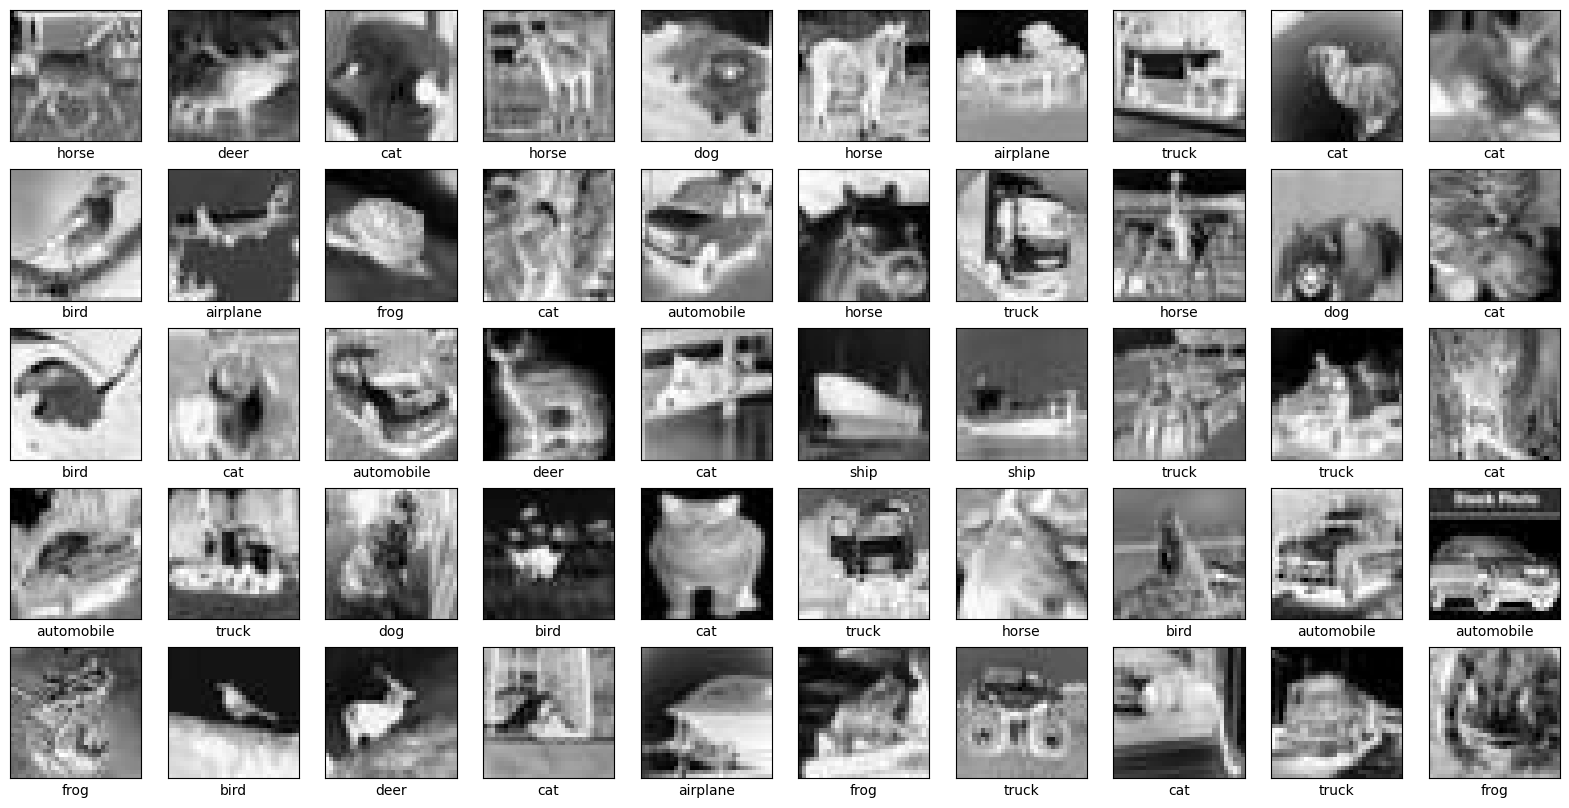

In [9]:
random.shuffle(training_data)
# Check Path
plt.figure(figsize=(20, 10))
i = 0
for data in training_data[:50]:
    plt.subplot(5, 10, i+1)
    plt.imshow(data[0], cmap='gray_r')
    plt.xlabel(CATEGORIES[data[1]])
    plt.xticks([])
    plt.yticks([])
    i += 1

# plt.tight_layout()
plt.show()

In [10]:
f1 = training_data[0:1000]
f2 = training_data[1000:2000]
f3 = training_data[2000:3000]
f4 = training_data[3000:4000]
f5 = training_data[4000:5000]
folds = [f1, f2, f3, f4, f5]


In [11]:
def manhattan_distance(img1, img2):
    return np.sum(np.abs(img1 - img2))


def euclidian_distance(img1, img2):
    return np.sqrt(np.sum((img1 - img2) ** 2))


def normalize(data):
    return [[np.round(img_array / 255, 3), class_num] for [img_array, class_num] in data]


def by_l1_dist(list):
    return list[2]["l1"]


def by_l2_dist(list):
    return list[2]["l2"]

In [12]:
top_filter = 20


def cal_dist(train_fold, valid_fold):
    l1_result = []
    l2_result = []
    for valid in tqdm(valid_fold):  # valid = [img_resized, class_num]
        temp_dist_list = []
        for train in train_fold:    # train = [img_resized, class_num]
            l1_dist = manhattan_distance(valid[0], train[0])
            l2_dist = euclidian_distance(valid[0], train[0])
            temp_dist_list.append([valid[1],  train[1], {"l1": l1_dist, "l2": l2_dist}])
        # sort by L1
        temp_dist_list.sort(key=by_l1_dist)
        l1_result.append(temp_dist_list[:top_filter])
        # sort by L2
        temp_dist_list.sort(key=by_l2_dist)
        l2_result.append(temp_dist_list[:top_filter])
    return [l1_result, l2_result]


In [13]:
k_range = 20


def cal_accuracy(dist_result, dist_term):
    k_accuracies = []  # k_range values
    for k in range(1, k_range+1):
        img_accuracy = 0
        for valid_img in dist_result:
            nn = valid_img[:k]
            same_class = [n for n in nn if n[0] == n[1]]
            same_class_len = len(same_class)
            if k % 2 != 0:                      # k is ODD
                if ((k-1) / 2) < same_class_len:  # majority has same class
                    img_accuracy += 1
            else:                                   # k is EVEN
                diff_class = [n for n in nn if n[0] != n[1]]
                if same_class_len > len(diff_class):    # majority has same class
                    img_accuracy += 1
                elif same_class_len == len(diff_class): # tie
                    same_class_dist = sum([n[2][dist_term] for n in same_class])
                    diff_class_dist = sum([n[2][dist_term] for n in diff_class])
                    if same_class_dist < diff_class_dist:   # same class has lesser distance
                        img_accuracy += 1
        k_accuracies.append(img_accuracy/len(dist_result))
    return k_accuracies


In [14]:
# PRE PROCESS
normal_folds = [normalize(data) for data in folds]


In [15]:
dist_by_fold = []

for fold_num in range(len(folds)):
  valid_fold = normal_folds[fold_num]
  train_fold = sum([fold for j, fold in enumerate(normal_folds) if fold_num != j], [])
  dist_by_fold.append(cal_dist(train_fold, valid_fold))  #[ l1_result, l2_result ] = cal_dist(train_fold, valid_fold)
    

100%|██████████| 1000/1000 [01:09<00:00, 14.39it/s]


In [16]:
accuracies = []

for result in dist_by_fold:
    l1_accuracy = cal_accuracy(result[0], "l1")
    l2_accuracy = cal_accuracy(result[1], "l2")
    accuracies.append([l1_accuracy, l2_accuracy])

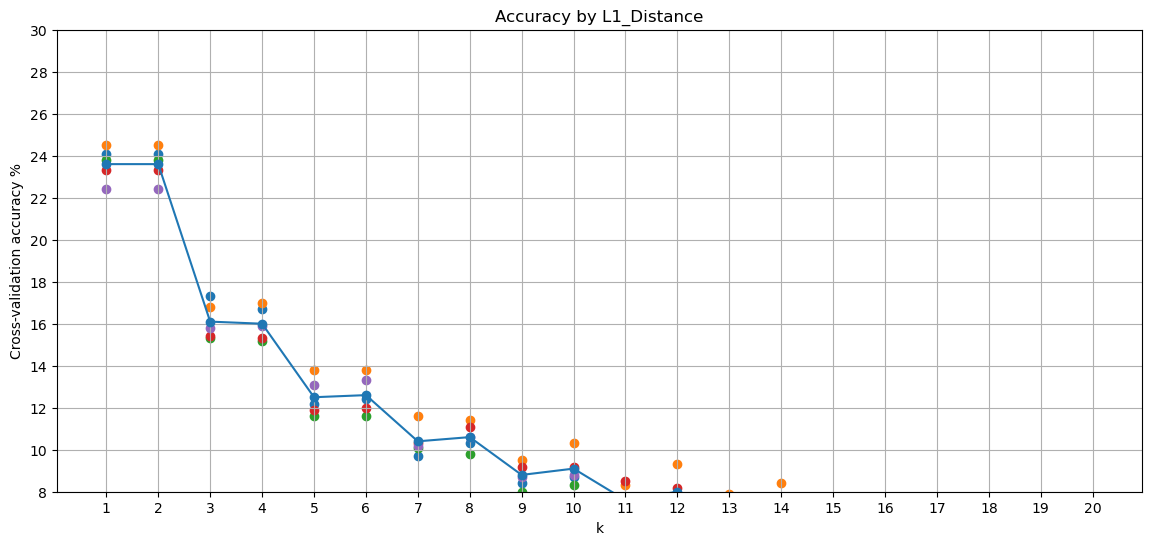

In [17]:
# Accuracy by L1_Distance
x_list = list(range(1, k_range+1))
plt.figure(figsize=(14, 6))

for fold in accuracies:
  y_list = [round(acc*100, 1) for acc in fold[0]] # fold[0] = l1_accurracy
  plt.scatter(x_list, y_list)
#calculate equation for quadratic trendline
arr = []
for i in range(k_range):
  arr.append([fold[0][i] for fold in accuracies])
trend = [round(np.mean(a)*100,1) for a in arr]
plt.errorbar(x_list, trend,fmt='-o')

plt.title('Accuracy by L1_Distance')
plt.xticks(x_list)
plt.yticks(list(range(8, 31, 2)))
plt.grid(True)
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy %')
plt.ylim([8, 30])

plt.show()

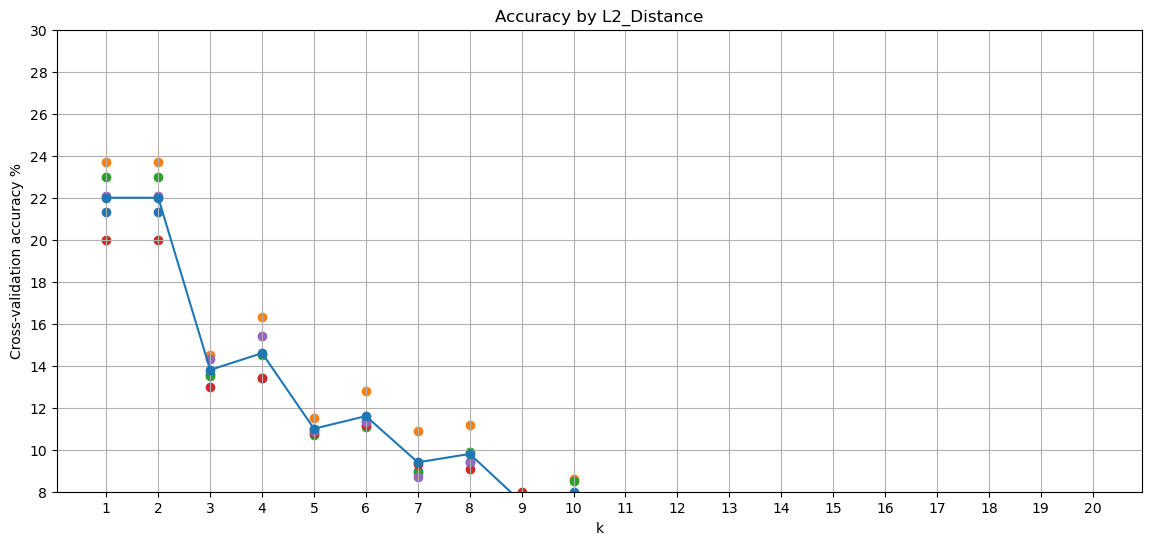

In [18]:
# Accuracy by L2_Distance
x_list = list(range(1, k_range+1))
plt.figure(figsize=(14, 6))

for fold in accuracies:
  y_list = [round(acc*100, 1) for acc in fold[1]] # fold[1] = l2_accurracy
  plt.scatter(x_list, y_list)
#calculate equation for quadratic trendline
arr = []
for i in range(k_range):
  arr.append([fold[1][i] for fold in accuracies])
trend = [round(np.mean(a)*100,1) for a in arr]
plt.errorbar(x_list, trend,fmt='-o')

plt.title('Accuracy by L2_Distance')
plt.xticks(x_list)
plt.yticks(list(range(8, 31, 2)))
plt.grid(True)
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy %')
plt.ylim([8, 30])

plt.show()

## Steps:
+ First, we have stored the training images in training_data as [img, class] pair.
+ Then we shuffled the list and took 5,000 training images before dividing them into 5-Fold.
+ Then, we normalized the pixel values from 0 to 1 for every image.
+ We calculated the Manhattan distance and Euclidian distance by taking a fold as validation and other folds as training.
+ Then calculated the accurracy for L1 and L2 separately.
+ Finally, plotted two scatter diagrams with mean accuracy for each k-value.

## Analysis:
  + In the graph of cross-validation accuracy of L1 distance, we have higher accuracy for every k value.
  + In the L1 accuracy graph, we have the highest mean accuracy when k=1 and k=2.
  + From k=3, the mean accuracy decreases because different classes may have the closest distance.
  + We have also analyzed that when k has an even value, the possibility to tie increases; therefore, we get less accuracy.
  